In [1]:
from flax.struct import dataclass
import jax.numpy as jnp
import jax
import jax.random
import optax

In [9]:
# If X sim N(0, 1) and Z sim N(0, 1), then
# we let Y = M_x * X + M_z * Z
@dataclass
class Coupling:
    M_x: float
    M_z: float

@jax.jit
def voi_diff(a: Coupling, b: Coupling) -> float:
    cov_Y = a.M_x @ a.M_x.T + a.M_z @ a.M_z.T
    cov_W = b.M_x @ b.M_x.T + b.M_z @ b.M_z.T
    cross_cov = a.M_x @ b.M_x.T + a.M_z @ b.M_z.T

    cov_Y_cond_W = cov_Y - cross_cov @ jnp.linalg.inv(cov_W) @ cross_cov.T
    cov_W_cond_Y = cov_W - cross_cov.T @ jnp.linalg.inv(cov_Y) @ cross_cov

    # For stability, we add a small value to the diagonal
    cov_Y_cond_W = cov_Y_cond_W + 1e-5 * jnp.eye(cov_Y_cond_W.shape[0])
    cov_W_cond_Y = cov_W_cond_Y + 1e-5 * jnp.eye(cov_W_cond_Y.shape[0])

    logdet_YW = jnp.linalg.slogdet(cov_Y_cond_W)[1]
    logdet_WY = jnp.linalg.slogdet(cov_W_cond_Y)[1]
    entropy_YW = 1/2*(logdet_YW + jnp.log(2 * jnp.pi * jnp.e) * cov_Y.shape[0])
    entropy_WY = 1/2*(logdet_WY + jnp.log(2 * jnp.pi * jnp.e) * cov_W.shape[0])
    # jax.debug.print("cond_cov Y|W: {}", cov_Y_cond_W)
    # jax.debug.print("cond_cov W|Y: {}", cov_W_cond_Y)
    # jax.debug.print("entropy_WY: {}", entropy_WY)
    # jax.debug.print("entropy_WY: {}", entropy_WY)
    return entropy_YW + entropy_WY

voi_diff(Coupling(jnp.ones((1,1)), 0.01*jnp.ones((1,1))), Coupling(1.*jnp.ones((1,1)), 0.01*jnp.ones((1,1))))

Array(-8.675048, dtype=float32)

In [10]:
@jax.jit
def loss_fn(init: Coupling, final: Coupling, trajectory: Coupling) -> float:
    left = jax.tree.map(lambda x: x[0], trajectory)
    right = jax.tree.map(lambda x: x[-1], trajectory)

    a = jax.tree.map(lambda x: x[:-1], trajectory)
    b = jax.tree.map(lambda x: x[1:], trajectory)
    left_diff = voi_diff(left, init)
    right_diff = voi_diff(right, final)
    middle_diff = jax.vmap(voi_diff)(a, b)
    return jnp.sum(middle_diff) + left_diff + right_diff

d = 1
loss_fn = jax.tree_util.Partial(
    loss_fn, Coupling(M_x=jnp.eye(d), M_z=jnp.zeros((d, d))), 
    Coupling(M_x=jnp.zeros((d, d)), M_z=jnp.eye(d))
)

In [19]:
T = 16
trajectory = Coupling(
    M_x=jax.random.uniform(jax.random.key(42), (16,d,d)),
    M_z=jax.random.uniform(jax.random.key(43), (16,d,d)),
)
iterations = 1000
optim = optax.adam(optax.cosine_decay_schedule(1e-2, 2000))
opt_state = optim.init(trajectory)
for i in range(iterations):
    loss, grad = jax.value_and_grad(loss_fn)(trajectory)
    updates, opt_state = optim.update(grad, opt_state)
    trajectory = optax.apply_updates(trajectory, updates)
    print(f"Iteration {i}: Loss = {loss}")

Iteration 0: Loss = 6.722111701965332
Iteration 1: Loss = 2.5084874629974365
Iteration 2: Loss = -4.40543270111084
Iteration 3: Loss = -7.726528644561768
Iteration 4: Loss = -13.88789176940918
Iteration 5: Loss = -22.745433807373047
Iteration 6: Loss = -26.13776397705078
Iteration 7: Loss = -29.959779739379883
Iteration 8: Loss = -33.36473846435547
Iteration 9: Loss = -32.53279113769531
Iteration 10: Loss = -35.64940643310547
Iteration 11: Loss = -35.256439208984375
Iteration 12: Loss = -35.13676452636719
Iteration 13: Loss = -39.338478088378906
Iteration 14: Loss = -38.901885986328125
Iteration 15: Loss = -43.361778259277344
Iteration 16: Loss = -46.08893966674805
Iteration 17: Loss = -44.85014724731445
Iteration 18: Loss = -48.77143096923828
Iteration 19: Loss = -57.54579162597656
Iteration 20: Loss = -62.322723388671875
Iteration 21: Loss = -58.49599838256836
Iteration 22: Loss = -56.819183349609375
Iteration 23: Loss = -57.33549118041992
Iteration 24: Loss = -59.36721420288086
Iter

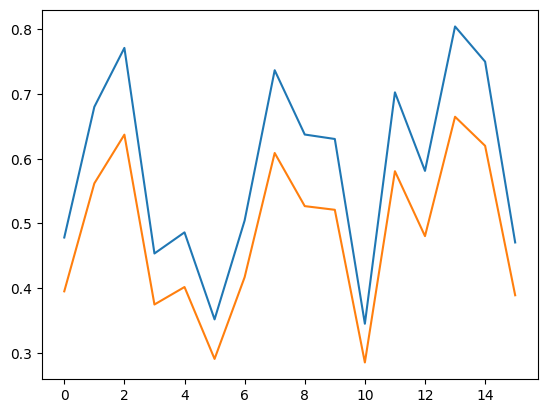

In [21]:
import matplotlib.pyplot as plt

plt.plot(jnp.arange(trajectory.M_x.shape[0]), trajectory.M_x[:,0,0], label='S1')
plt.plot(jnp.arange(trajectory.M_z.shape[0]), trajectory.M_z[:,0,0], label='S2')